In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2022-12-31 21:23:37--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-12-31 21:23:37--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.87MB/s    in 5m 6s   

2022-12-31 21:28:43 (4.75 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords


inputFile = "/content/drive/MyDrive/AI2/ergasia_1/imdb-reviews.csv"

# Insert the path of the file you want to test HERE
testFile = None

df = pd.read_csv(inputFile, sep='\t')

# Drop the first column (url)
df = df.drop(columns=['url'])

positive = 0
negative = 0
neutral = 0

nltk.download('stopwords')


for index, row in df.iterrows():
    # if score is greater than 7, it is positive so change its value to 1, else 0
    if row["rating"] >= 7:
        positive += 1
        df.at[index, "rating"] = 1
    elif row["rating"] <= 4:
        negative += 1
        df.at[index, "rating"] = 0
    else:
        neutral += 1
    # To Remove the stop words uncomment the below line. Does not improve accuracy
    # df.at[index, "review"] = ' '.join([word for word in row["review"].split() if word not in (stopwords.words('english'))])

# Get the GloVe word embeddings
gloveFile = "glove.twitter.27B.200d.txt"

embeddings = {}
with open(gloveFile, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Split the data into train 80% , test 10% and validation 10% sets

train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)
test = test.sample(frac=0.5, random_state=42)
validation = df.drop(train.index)
validation = validation.drop(test.index)

if testFile is not None:
    test = pd.read_csv(testFile, sep='\t')
    test = test.drop(columns=['url'])

# print df, train, test, validation sizes
print("df size: ", df.shape)
print("train size: ", train.shape)
print("test size: ", test.shape)
print("validation size: ", validation.shape)

df size:  (45008, 2)
train size:  (36006, 2)
test size:  (4501, 2)
validation size:  (4501, 2)


In [17]:
# Get X_train, y_train, X_test, y_test, X_validation, y_validation
X_train = train["review"]
y_train = train["rating"]
X_test = test["review"]
y_test = test["rating"]
X_validation = validation["review"]
y_validation = validation["rating"]


# Create word vectors for train, test and validation sets
def createWordVectors(data):
  wordVectors = [];
  for row in data:
    sum = np.zeros(len(embeddings["hello"]));
    word_count = 0;
    for word in row.split():
      if word in embeddings:
        sum = sum + embeddings[word];
        word_count = word_count+1;
    if word_count != 0:
      wordVectors.append(sum/word_count);
    else:
      wordVectors.append(np.zeros(len(embeddings["hello"])))

  wordVectors = np.array(wordVectors, dtype=np.float32)
  return wordVectors


X_train = createWordVectors(X_train)
X_test = createWordVectors(X_test)
X_validation = createWordVectors(X_validation)

# Convert the word vectors from ndarrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
X_validation = torch.tensor(X_validation, dtype=torch.float)

# Convert the labels to tensors
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)
y_validation = torch.tensor(y_validation.values, dtype=torch.float)


In [18]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        # self.softmax = nn.Softmax(dim=D_out)

        
    def forward(self, x):
        # If dropout is activated consider increasing the size of each hidden layer

        h1 = self.linear1(x)
        # h1 = F.selu(h1)
        # h1 = F.torch.sigmoid(h1)
        # h1 = F.elu(h1)
        h1 = F.relu(h1)
        # h1 = F.dropout(h1, p=0.5, training=self.training)

        h2 = self.linear2(h1)
        # h2 = F.selu(h2)
        # h2 = F.torch.sigmoid(h2)
        # h2 = F.elu(h2)
        h2 = F.relu(h2)
        # h2 = F.dropout(h2, p=0.5, training=self.training)

        h3 = self.linear3(h2)
        # h3 = F.selu(h3)
        # h3 = F.torch.sigmoid(h3)
        # h3 = F.elu(h3)
        h3 = F.relu(h3)
        # h3 = F.dropout(h3, p=0.5, training=self.training)

        out = self.linear4(h3)

        return out

# HYPERPARAMETERS

In [19]:
# Define layer sizes
D_in = X_train.shape[1]
H1 = 200
H2 = 100
H3 = 50
D_out = 1

# Define hyperparameters
learning_rate = 2e-5

#Initialize model, loss, optimizer
model = Net(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss(reduction='sum')
# loss_func = nn.MSELoss(reduction='mean')
# loss_func = nn.L1Loss(reduction='sum')
# loss_func = nn.CrossEntropyLoss()
# loss_func = nn.NLLLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)        # Bad results, not comparable to other optimizers
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)        # lr = 2e-5, batch_size = 16, 50 epochs
# optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)     # lr = 5e-5, batch_size = 8, 60 epochs OR lr = 6e-5, batch_size = 128, 200 epochs
# optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)      # lr = 1e-4, batch_size = 32, 100 epochs
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)    # lr = 1e-4, batch_size = 64, 100 epochs
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)   # lr = 1e-2, batch_size = 64, 100 epochs
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)      # lr = 2e-5, batch_size = 64, 100 epochs
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)       # lr = 3e-5, batch_size = 32, 100 epochs
# optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)       # lr = 3e-4, batch_size = 128, 100 epochs, very choppy learning curve


# Initialize dataloader
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [20]:
# Train the model
epochs = 50

train_loss = []
val_loss = []

for epoch in range(epochs):
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    y_batch = y_batch.unsqueeze(-1)

    
    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss.item())
    
    # Delete previously stored gradients
    optimizer.zero_grad()
    # Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    # Update model's weights based on the gradients calculated during backprop
    optimizer.step()
  
  with torch.no_grad():
    Y_train_pred = model(X_train);
    loss_train = loss_func(Y_train_pred, y_train.unsqueeze(-1))/Y_train_pred.shape[0]
    train_loss.append(loss_train.item());
    Y_val_pred = model(X_validation);
    loss_val = loss_func(Y_val_pred, y_validation.unsqueeze(-1))/Y_val_pred.shape[0]
    val_loss.append(loss_val.item());

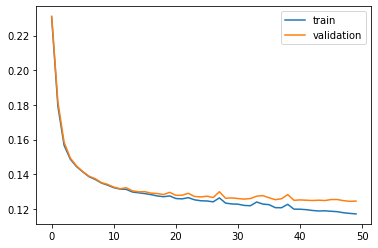

In [21]:
# Plot the learning curves for train and validation sets
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.show()


In [22]:
# Calculate the precision, recall and f1 score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Print the metrics for the train, test and validation sets
def print_metrics(y_true, y_pred, title):
    precision, recall, f1 = calculate_metrics(y_true, y_pred)
    print(f"{title:10} --> Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Print the metrics for the train set
y_pred = model(X_train)
print_metrics(y_train, y_pred, "Train")

# Print the metrics for the validation set
y_pred = model(X_validation)
print_metrics(y_validation, y_pred, "Validation")

# Print the metrics for the test set
y_pred = model(X_test)
print_metrics(y_test, y_pred, "Test")


Train      --> Precision: 0.828, Recall: 0.847, F1: 0.837
Validation --> Precision: 0.822, Recall: 0.833, F1: 0.828
Test       --> Precision: 0.834, Recall: 0.837, F1: 0.836


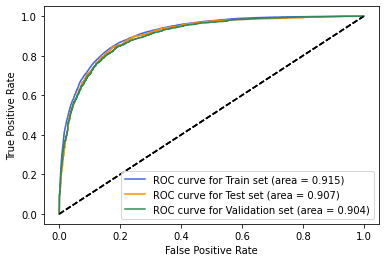

In [23]:
# Print ROC curves for train, test and validation sets on the same plot

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, title, color):
    fpr, tpr, _ = roc_curve(y_true.detach(), y_pred.detach())
    plt.plot(fpr, tpr, label=f"ROC curve for {title} set (area = {auc(fpr, tpr):.3f})", color=color)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

# Plot the ROC curve for the train set
y_pred = model(X_train)
plot_roc_curve(y_train, y_pred, "Train", "royalblue")

# Plot the ROC curve for the test set
y_pred = model(X_test)
plot_roc_curve(y_test, y_pred, "Test", "darkorange")

# Plot the ROC curve for the validation set
y_pred = model(X_validation)
plot_roc_curve(y_validation, y_pred, "Validation", "seagreen")

plt.show()